In [4]:
import numpy as np
import random
# For optimization
from scipy.optimize import Bounds, BFGS                     
from scipy.optimize import LinearConstraint, minimize   
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
# For generating dataset
import sklearn.datasets as dt

#credit: https://machinelearningmastery.com/method-of-lagrange-multipliers-the-theory-behind-support-vector-machines-part-3-implementing-an-svm-from-scratch-in-python/

### Here we look at the simplest SVM. The goal is to separate one kind of data from another; the separatrix being a hyperplane that needs to be optimized for. In short, this is a classification tool that makes predictions for the category a new point belongs to.
### They are also called maximum margin classifiers because the algorithm finds the separatrix that has the longest perpendicular distance to any one point. In your head, you should be picturing a blue cluster of points and a red cluster of points, and rotating a line until it hits no points, and then maximizing perpendicular distance to the nearest point.

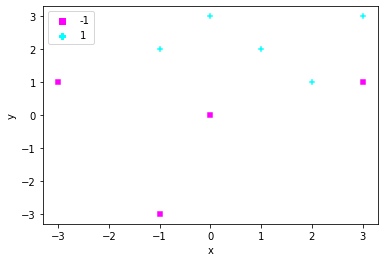

In [170]:
#create dataset with labels. 
X = np.array([[0, 3], [-1, 2], [1, 2], [2, 1], [3,3], [0, 0], [-1, -3], [-3, 1], [3, 1]])
Y = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1])

plt.figure()
sns.scatterplot(x=X[:,0], y=X[:, 1], style=Y, hue=Y, markers=['s', 'P'], palette=['magenta', 'cyan'])
plt.xlabel('x')
_=plt.ylabel('y')

### sklearn has an SVM implementation. Let's use that to show what it does!
#### StandardScaler() is used for pre-processing, gamma is Kernel coeff.

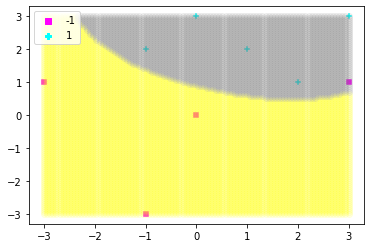

In [114]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, Y)
X_test = np.linspace(-3, 3, 100)
Y_test = np.linspace(-3, 3, 100)

plt.figure()
sns.scatterplot(x=X[:,0], y=X[:, 1], style=labels, hue=Y, markers=['s', 'P'], palette=['magenta', 'cyan'])
for y in Y_test:
    for x in X_test:
        res = clf.predict([[x, y]])
        if res[0] == -1:
            plt.scatter([x], [y], c='yellow', alpha = 0.1)
        else:
            plt.scatter([x], [y], c='gray', alpha = 0.1)
            continue
plt.show()

### The purpose of the above was just to illustrate how it works. But we want to build our own

## 3.1 Hard-margin

### Finding the hyperplane: define $\vec{w}$ as the vector normal to the hyperplane which contains points $\vec{x}$. $b\|\vec{w}\|$ is the offset of hyperplane from the origin along normal vector $\vec{w}$.
### The hyperplane is the $\vec{w}^T\vec{x} - b = 0$
### We can have two such hyperplanes, one for each category. These are $\vec{w}^T\vec{x} - b = 1$ and $\vec{w}^T\vec{x} - b = -1$.
### Any point above the first belongs to category ''1'' and anything below the second belongs to category ''-1''
### For each datapoint $i$, $y_i(\vec{w}^Tx_i - b)\geq 1$. This puts the constraint on datapoints to be on either side of the pair of hyperplanes. 
### We want to maximize margin: minimize $\|w\|^2_2$ subject to the above constraint.

## 3.2 Soft-margin

### In the case of soft-margin, the two datasets can't be separated with just a straight line. 
### The problem becomes the minimizing of $\|w\|^2_2 + C \Sigma_1^N \zeta_i$, where $C$ is a regularization constant (large $C$ means we are back to the hard-margin problem), and $\zeta_i$ quantifies error in classification. The constraint is  $y_i(\vec{w}^Tx_i - b)\geq 1-\zeta_i.$
### In optimization problems, if the primal consists of minimizing some function, the dual is the maximization of a different function. Using Lagrange multipliers, an objective function known as the Lagrange dual is found. It is $L_d = -\frac{1}{2}\Sigma_i\Sigma_k\alpha_i\alpha_k y_i y_k (x_i^T)(x_k) + \Sigma_i \alpha_i$. $\alpha$ is a vector of Lagrange multipliers. We need to solve for $\alpha$ having constraining $\Sigma_i \alpha_iy_i = 0$. Minimize $L_d$ or maximize $-L_d$.
### The hyperplane is $\vec{w}^T\vec{x} - b = 0$, where $\vec{w} = \Sigma_i \alpha_iy_ix_i$. For a single support vector $s$, $b = \vec{w}^T\vec{w_s} - y_s$.

In [137]:
ZERO = 1e-7

#let's start with the objective function
def lagrange_dual(alpha, x, y):
    res = 0
    ind = np.where(alpha>ZERO)[0]
    for i in ind:
        for k in ind:
            res += alpha[i]*alpha[k]*y[i]*y[k]*\
            np.dot(x[i,:], x[k, :])
    res = 0.5*res - np.sum(alpha)
    return res

#tackle the linear constraint sum(alpha_i*y_i) = 0.
linear_constraint = LinearConstraint(labels, [0], [0])

#define bounds on alpha
bnds = Bounds(np.zeros(X.shape[0]), np.full(X.shape[0], 10))

#optimize to find alpha
def optimize_alpha(x, y, C):
    m, n = x.shape
    # Initialize alphas to random values
    alpha_0 = np.random.rand(m)*C
    # Define the constraint
    linear_constraint = LinearConstraint(y, [0], [0])
    # Define the bounds
    bnds = Bounds(np.zeros(m), np.full(m,C))
    # Find the optimal value of alpha
    result = minimize(lagrange_dual, alpha_0, args = (x,y),\
                      method = 'trust-constr', hess = BFGS(),\
                      constraints = [linear_constraint], bounds = bnds)
    # The optimized value of alpha lies in result.x
    alpha = result.x
    return alpha

#get b
def get_b(alpha, y, x, w, C):
    C_numeric = C-ZERO
    # Indices of support vectors with alpha<C
    ind = np.where((alpha>ZERO) & (alpha<C_numeric))[0]
    b = 0.
    for s in ind:
        b+= np.dot(x[s,:],w) - y[s]
    # Take the average
    b /= len(ind)
    return b

#finally, get w
def get_w(alpha, y, x):
    m = len(x)
    # Get all support vectors
    w = np.zeros(x.shape[1])
    for i in range(m):
        w += alpha[i]*y[i]*x[i, :]
    return w

#predict
def classify_points(x_test, w, b):
    # Get y(x_test)
    predicted_labels = np.sign(np.sum(x_test*w, axis = 1) - b)
    # Assign a label arbitrarily a +1 if it = 0
    predicted_labels[predicted_labels == 0] = 1
    return predicted_labels

def misclassification_rate(labels, predictions):
    total = len(labels)
    errors = sum(labels != predictions)
    return errors/total*100

In [157]:
alpha = optimize_alpha(X, Y, 5)
w = get_w(alpha, Y, X)
b = get_b(alpha, Y, X, w, 5)

C:\Users\ajati\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


### Run on some test data

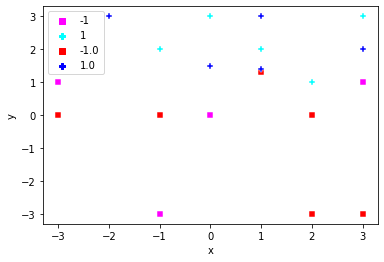

In [211]:
plt.figure()
sns.scatterplot(x=X[:,0], y=X[:, 1], style=Y, hue=Y, markers=['s', 'P'], palette=['magenta', 'cyan'])
plt.xlabel('x')
_=plt.ylabel('y')

X_test = np.array([[-2, 3], [-1, 0], [1, 1.3], [1, 1.4], [1, 3], [2,-3], [2, 0], [3, -3], [-3, 0], [3, 2], [0, 1.5]])
res = classify_points(X_test, w, b)
sns.scatterplot(x=X_test[:,0], y=X_test[:, 1], style=res, hue=res, markers=['s', 'P'], palette=['red', 'blue'])
plt.show()

### Misclassification rate: for soft-margin, the presence of error means that we are not assuming the given labels are perfect. Assume there is some error in that. Classify using SVM, and then go back and report how much this error is, given this classification.

In [214]:
res = classify_points(X, w, b)
mr = misclassification_rate(Y, res)
print('{}%'.format(mr))

11.11111111111111%
